# Graph Operations

Graphs are often useful in analytic applications. We can use them to represent probabilistic or causal models because they can be straightforwardly projected on to joint probability distributions. We can also use them to model deterministic or stochastic processes, or even just to relate pieces of information as a basic data structure. Graphs are useful for all of these use cases because they are quite flexible. In this notebook we will focus on Directed Acyclic Graphs and operations on them.

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from typing import List, Tuple, Dict, Any, Callable, TypeVar
from dataclasses import dataclass
import statsconcepts.graph_utils as gu

A = TypeVar('A')
B = TypeVar('B')

%load_ext autoreload
%aimport statsconcepts.graph_utils
%autoreload 1

## Preliminaries

To start, graph construction is straightforward. We can simply specify the nodes as keys, and the nodes they connect to as values in an adjacency dictionary which can then be fed into a graph constructor. We use `DiGraph` here to specify we want directed edges.

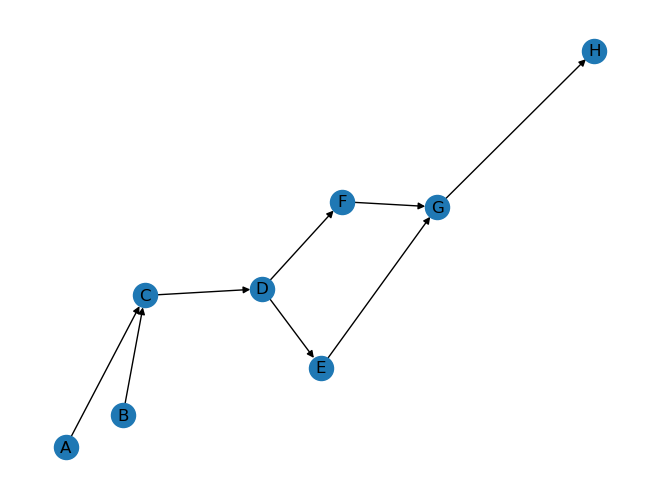

In [2]:
letter_graph: Dict[str, List[str]] = {
    "A": ["C"],
    "B": ["C"],
    "C": ["D"],
    "D": ["E", "F",],
    "E": ["G"],
    "F": ["G"],
    "G": ["H"],
}
L = nx.DiGraph(letter_graph)
nx.draw(L, with_labels=True)

Note how the above graph is acyclic (i.e. contains no cycles). By contrast, the graph below does contain a cycle. If you are trying to represent a causal system, you can see why this might be a problem.

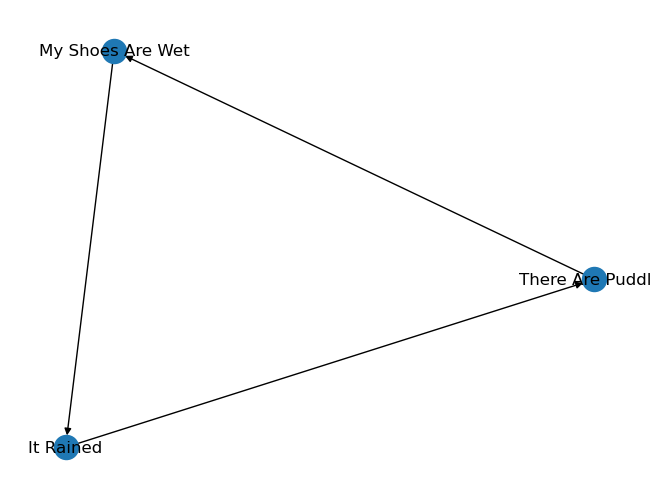

In [3]:
circular_reasoning: Dict[str, List[str]] = {
    "It Rained": ["There Are Puddles"],
    "There Are Puddles": ["My Shoes Are Wet"],
    "My Shoes Are Wet": ["It Rained"]
}
C: nx. DiGraph = nx.DiGraph(circular_reasoning)
nx.draw(C, with_labels=True)

To examine the graph, we can inspect nodes and edges, en masse or individually.

In [4]:
print("Nodes:", L.nodes)
print("Edges:", L.edges)
print("Parents of D:", list(L.predecessors("D")))
print("Children of D:", list(L.successors("D")))
print("Degree of F:", L.degree["F"])
print("In-Degree of F:", L.in_degree["F"])
print("Out-Degree of F:", L.out_degree["F"])

Nodes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
Edges: [('A', 'C'), ('B', 'C'), ('C', 'D'), ('D', 'E'), ('D', 'F'), ('E', 'G'), ('F', 'G'), ('G', 'H')]
Parents of D: ['C']
Children of D: ['E', 'F']
Degree of F: 2
In-Degree of F: 1
Out-Degree of F: 1


More often than not, we are not going to want to represent a simple node, but rather one with attributes. Any hashable object can be used as a node.

In [ ]:
@dataclass
class RibSmoke:
    stage: str
    time: int

    def __hash__(self):
        return hash(self.stage)

ribs: Dict[str, RibSmoke] = {
    "Buy Ribs": RibSmoke("Buy Ribs", 60),
    "Season Ribs": RibSmoke("Season Ribs", 30),
    "Dry Store": RibSmoke("Dry Store", 720),
    "Soak Wood Chips": RibSmoke("Soak Wood Chips", 720),
    "Smoke Ribs": RibSmoke("Smoke Ribs", 360),
    "Profit": RibSmoke("Profit", 10),
}

ribs_adjacency: Dict[RibSmoke, List[RibSmoke]] = {
    ribs["Buy Ribs"]: [ribs["Season Ribs"]],
    ribs["Season Ribs"]: [ribs["Dry Store"], ribs["Soak Wood Chips"]],
    ribs["Dry Store"]: [ribs["Smoke Ribs"]],
    ribs["Soak Wood Chips"]: [ribs["Smoke Ribs"]],
    ribs["Smoke Ribs"]: [ribs["Profit"]],
}

R: nx.DiGraph = nx.DiGraph(ribs_adjacency)
nx.nx_agraph.to_agraph

<function networkx.drawing.nx_agraph.to_agraph(N)>

Using nodes directly this way is a little cumbersome...

In [6]:
"What comes after buying ribs?", list(R.successors(RibSmoke("Buy Ribs", 60)))

('What comes after buying ribs?', [RibSmoke(stage='Season Ribs', time=30)])

What comes after buying ribs? ['Season Ribs']
How long should I dry store? 720


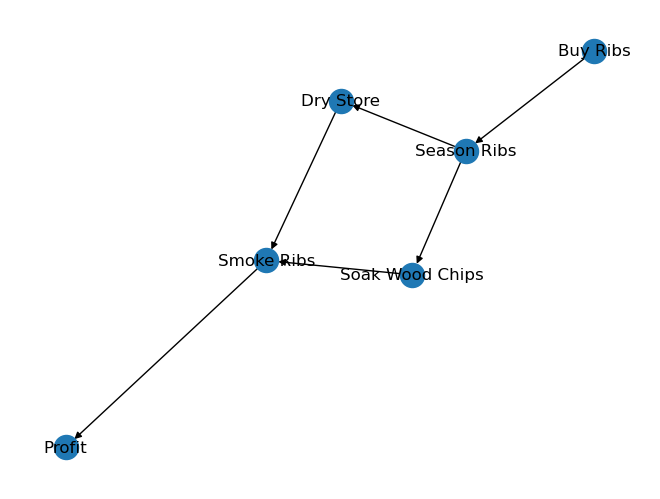

In [7]:
s_ribs_adjacency: Dict[str, List[str]] = {
    "Buy Ribs": ["Season Ribs"],
    "Season Ribs": ["Dry Store", "Soak Wood Chips"],
    "Dry Store": ["Smoke Ribs"],
    "Soak Wood Chips": ["Smoke Ribs"],
    "Smoke Ribs": ["Profit"],
}

R2: nx.DiGraph = nx.DiGraph(s_ribs_adjacency)
for node in R2.nodes:
    R2.nodes[node]["stage"] = ribs[node]

nx.draw(R2, with_labels=True)
print("What comes after buying ribs?", list(R2.successors("Buy Ribs")))
print("How long should I dry store?", R2.nodes["Dry Store"]["stage"].time)

## Operating on Graphs

While inspecting graphs is pleasant, we are here to do analysis. To get a sense of how we might go about this, let's ask two basic questions:

1. All of the times for each step in the rib preparation and consumption process are expressed in minutes. Can we get the same graph with times expressed in hours?
2. What is the total end to end time expressed in hours?

### Map

The first question requires us to visit every node and convert the time to hours. This an example of a functor commonly called `map()`. It has the type signature `(A -> B) -> F[A] -> F[B]` meaning given a function that converts a value from type `A` to `B` (i.e. `(A -> B)`), we can convert every value of type `A` in context `F` into a value of type `B`. In this case, our values of type `A` are instances of `RibSmoke` with time expressed as minutes and our values of type `B` are instances of `RibSmoke` with time expressed in hours. Our context (`F`) is `R2`, our instance of `nx.DiGraph`. (Contexts can be anything, like lists, sets, etc.)

Let's define `(A -> B)`.

In [8]:
def minutes_to_hours(node_attr: Dict[str, RibSmoke]) -> Dict[str, RibSmoke]:
    """
    Our nodes are actually just dictionaries under the hood. We
    are going to modify the stage of each to hold a RibSmoke object
    with time in hours instead of minutes. Technically we are 
    operating on the dictionary containing an instance of RibSmoke,
    and not the RibSmoke instance itself. But, for clarity, we will
    mark A and B as the RibSmoke objects because that's where the 
    action is.
    
    A: RibSmoke object with time in minutes 
    B: RibSmoke object with time in hours
    """
    to_hours: Callable[[RibSmoke], RibSmoke] = lambda x: RibSmoke(x.stage, x.time / float(60))
    print("Original Node Attributes:", node_attr)
    new_node_attr: Dict[str, RibSmoke] = {"stage": to_hours(node_attr["stage"])}
    return new_node_attr

Now we need some way of visiting the nodes. The absolute simplest way to do this is to just leverage the fact that we have all the nodes to begin with. They are definitional for the graph, and we can just actually ignore their relationships entirely. If we iterate over them as though they are in a list and transform them along the way, we can reconstitute the graph in the same way that we built it initially. Here is what that transformation would look like.

In [9]:
[node for node in R2.nodes.values()]

[{'stage': RibSmoke(stage='Buy Ribs', time=60)},
 {'stage': RibSmoke(stage='Season Ribs', time=30)},
 {'stage': RibSmoke(stage='Dry Store', time=720)},
 {'stage': RibSmoke(stage='Soak Wood Chips', time=720)},
 {'stage': RibSmoke(stage='Smoke Ribs', time=360)},
 {'stage': RibSmoke(stage='Profit', time=10)}]

In [10]:
[minutes_to_hours(node) for node in R2.nodes.values()]

Original Node Attributes: {'stage': RibSmoke(stage='Buy Ribs', time=60)}
Original Node Attributes: {'stage': RibSmoke(stage='Season Ribs', time=30)}
Original Node Attributes: {'stage': RibSmoke(stage='Dry Store', time=720)}
Original Node Attributes: {'stage': RibSmoke(stage='Soak Wood Chips', time=720)}
Original Node Attributes: {'stage': RibSmoke(stage='Smoke Ribs', time=360)}
Original Node Attributes: {'stage': RibSmoke(stage='Profit', time=10)}


[{'stage': RibSmoke(stage='Buy Ribs', time=1.0)},
 {'stage': RibSmoke(stage='Season Ribs', time=0.5)},
 {'stage': RibSmoke(stage='Dry Store', time=12.0)},
 {'stage': RibSmoke(stage='Soak Wood Chips', time=12.0)},
 {'stage': RibSmoke(stage='Smoke Ribs', time=6.0)},
 {'stage': RibSmoke(stage='Profit', time=0.16666666666666666)}]

This would be the most efficient implementation, because it scales linearly (i.e. the cost of the operation is linear in the number of nodes). However, what's the fun in that? We are going to do it inefficiently by not ignoring the structure of the graph. The motivation here is not inefficiency for it's own sake, but because understanding how graph traversal works actually helps us on other tasks by forcing us to encode a general traversal method: depth first search.

In [11]:
test = [1,2,3,4,5]

new_test = []
for t in test:
    new_test.append(t + 1)
print("New Test:", new_test)

New Test: [2, 3, 4, 5, 6]


In [12]:
def my_map(f: Callable[[A], B], lst: List[A]) -> List[B]:
    out: List[B] = []
    for l in lst:
        out.append(f(l))
    return out

print(my_map(lambda x: x + 1, test))
print(my_map(lambda x: str(x) + "_0", test))

def to_as(x: int) -> str:
    return "a"*x

print(my_map(to_as, test))

[2, 3, 4, 5, 6]
['1_0', '2_0', '3_0', '4_0', '5_0']
['a', 'aa', 'aaa', 'aaaa', 'aaaaa']


Original Node Attributes: {'stage': RibSmoke(stage='Buy Ribs', time=60)}
Original Node Attributes: {'stage': RibSmoke(stage='Season Ribs', time=30)}
Original Node Attributes: {'stage': RibSmoke(stage='Dry Store', time=720)}
Original Node Attributes: {'stage': RibSmoke(stage='Smoke Ribs', time=360)}
Original Node Attributes: {'stage': RibSmoke(stage='Profit', time=10)}
Original Node Attributes: {'stage': RibSmoke(stage='Soak Wood Chips', time=720)}
New Node Attributes: {'stage': RibSmoke(stage='Buy Ribs', time=1.0)}
New Node Attributes: {'stage': RibSmoke(stage='Season Ribs', time=0.5)}
New Node Attributes: {'stage': RibSmoke(stage='Dry Store', time=12.0)}
New Node Attributes: {'stage': RibSmoke(stage='Smoke Ribs', time=6.0)}
New Node Attributes: {'stage': RibSmoke(stage='Profit', time=0.16666666666666666)}
New Node Attributes: {'stage': RibSmoke(stage='Soak Wood Chips', time=12.0)}


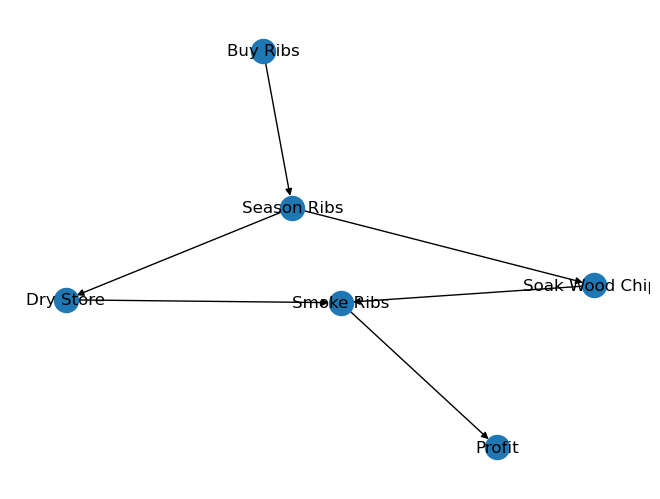

In [13]:
def depth_first_map(
    g: nx.DiGraph, # original graph
    source_node: str, # node to start from
    f: Callable[[A], B], # function to apply to each node
    out_graph: nx.DiGraph = nx.DiGraph() # graph to store results
) -> nx.DiGraph:
    
    # Need to keep track of the nodes we have already visited
    marked: Dict[str, bool] = {n: False for n in g.nodes}

    # Only need to add the source node the first time. After that,
    # the source node in recursive calls are just the previous children
    if source_node not in out_graph.nodes:
        out_graph.add_node(source_node)
        for k, v in f(g.nodes[source_node]).items():
            out_graph.nodes[source_node][k] = v

    # Successors returns an iterator; converting to a list to preserve it
    children = list(g.successors(source_node))

    # For each child, if it hasn't been marked, add it to the graph
    for child in children:
        if child not in out_graph.nodes:
            out_graph.add_node(child)
            for k, v in f(g.nodes[child]).items():
                out_graph.nodes[child][k] = v
            marked[child] = True
            # Recursively call depth_first_map on the child
            depth_first_map(g, child, f, out_graph)
        # Add the edge from the source node to the child here
        # because we need to be able to connect multiple parents
        # to the same child
        out_graph.add_edge(source_node, child)

    return out_graph

R2_hours: nx.DiGraph = depth_first_map(R2, "Buy Ribs", minutes_to_hours)
for n in R2_hours.nodes.values():
    print(f"New Node Attributes:", n)
nx.draw(R2_hours, with_labels=True)

So what just happened there? We were able to leverage recursion to visit each node, adding nodes as we traversed the graph and adding edges on the way back:

+ Call 0: We initiated `out_graph` with the `Buy Ribs` source node, and added the child `Season Ribs`. 
    + Call 1: We recursively called `depth_first_map()` again, this time with `Season Ribs` as the source node. To prepare for another recursive call, we again needed to add a new child to serve as the new source node. But, there were now two children: `Dry Store` and `Soak Wood Chips`. Since `Dry Store` was first in the `children` list, we followed that path first. 
        + Call 2: Another recursive call on `Dry Store` as source node with child `Smoke Ribs` added.
            + Call 3: Another recursive call on `Smoke Ribs` as source node with child `Profit` added.
                + Call 4: Another recursive call on `Profit` as source node, but `Profit` has no children. So, we returned the graph, which means we proceeded back up the stack to proceed with adding edges.
            + Call 3: We added the edge from `Smoke Ribs` (source node) to `Profit` (child) and return the graph.
        + Call 2: We added the edge from `Dry Store` (source node) to `Smoke Ribs` (child) and return the graph.
    + Call 1: We added the edge from `Season Ribs` (source node) to `Dry Store` (child) and remembered that we had another child of `Season Ribs`! 
        + Call 2: Another recursive call on `Soak Wood Chips` as the source node. The child here would have been `Smoke Ribs`, but it was already in the graph. We skipped the addition of a redundant node and added the edge from `Soak Wood Chips` to `Smoke Ribs` and returned the graph.
    + Call 1: We added the edge from `Season Ribs` to `Dry Store` and returned the graph.
+ Call 0: We added the edge from `Buy Rib` to `Season Ribs` and returned the graph outside of the function scope to the original collar.

Recursion allows us to use the call stack to our advantage when we have naturally recursive structures (e.g. graphs or trees). We can also use it to perform reductions, which helps us with our second question.

### Fold

Now we want to resolve many values of type `A` (in this case, nodes) down to a single value of type `B` (total cook time). The function signature is now `((A, B) -> B) -> F[A] -> B`. The first portion `(A, B) -> B` allows us to take a new node `A` and combine it with our running value of `B` for a new value of type `B`. If we do this for all values in our context `F` (i.e. our graph) we can compute a single value of `B` on the other side. The easiest way to see this is with a list as our context.

In [21]:
def fold_list(xs: List[A], f: Callable[[A, B], B], zero: B) -> B:
    """
    Fold a list using a function f and an initial value zero.
    """
    result: B = zero
    for x in xs:
        result = f(x, result)
    return result

fold_list([1, 2, 3], lambda x, y: x + y, 0) == 6

True

In [22]:
{n: R2_hours.nodes[n]["stage"] for n in R2.nodes}

{'Buy Ribs': RibSmoke(stage='Buy Ribs', time=1.0),
 'Season Ribs': RibSmoke(stage='Season Ribs', time=0.5),
 'Dry Store': RibSmoke(stage='Dry Store', time=12.0),
 'Soak Wood Chips': RibSmoke(stage='Soak Wood Chips', time=12.0),
 'Smoke Ribs': RibSmoke(stage='Smoke Ribs', time=6.0),
 'Profit': RibSmoke(stage='Profit', time=0.16666666666666666)}

In [ ]:
def fold_graph(g: nx.DiGraph, fold: Callable[[A, B], B], combine: Callable[[B, B], B], zero: B) -> B:
    out: B = zero
    for node in g.nodes:
        pred_nodes: List[str] = list(g.predecessors(node))

        # if len(pred_nodes) == 0:
        #     out = fold(g.nodes[node], out)
        if len(pred_nodes) > 0:
            pre_vals: List[B] = [fold(g.nodes[pred], out) for pred in pred_nodes]
            out = pre_vals[0] if len(pre_vals) == 1 else fold_list(pre_vals, combine, zero)
        else:
            out = fold(g.nodes[node], out)
    return out


def fold_stage_time(node_attr: Dict[str, RibSmoke], accumulated_time: float) -> float:
    """
    A: Dict[str, RibSmoke]
    B: float
    """
    return node_attr["stage"].time + accumulated_time

def combine_stage_time(a: float, b: float) -> float:
    """
    B: float
    B: float
    """
    return max(a, b)

total_time: float = fold_graph(R2_hours, fold_stage_time, combine_stage_time, 0)
print("Total Time:", total_time)

KeyboardInterrupt: 

In [17]:
def fold_list_recursive(xs: List[A], f: Callable[[A, B], B], zero: B) -> B:
    head, *tail = xs
    if len(xs) == 1:
        return f(zero, head)
    else:
        return fold_list_recursive(tail, f, f(zero, head))
    
fold_list_recursive([1, 2, 3], lambda x, y: x + y, 0) == 6

True

For our graph, we will again need to make sure we can touch all of the nodes in the graph, so we can apply the following function for our total cook time.

The twist is that stages that can operate in parallel should not count twice.

In [18]:
def add_stage_time(source_node: str, in_g: nx.DiGraph, accumulated_time: float) -> float:
    """
    A: nx.DiGraph
    B: float
    """

    

In [19]:
[n for n in R2.nodes.items()]

[('Buy Ribs', {'stage': RibSmoke(stage='Buy Ribs', time=60)}),
 ('Season Ribs', {'stage': RibSmoke(stage='Season Ribs', time=30)}),
 ('Dry Store', {'stage': RibSmoke(stage='Dry Store', time=720)}),
 ('Soak Wood Chips', {'stage': RibSmoke(stage='Soak Wood Chips', time=720)}),
 ('Smoke Ribs', {'stage': RibSmoke(stage='Smoke Ribs', time=360)}),
 ('Profit', {'stage': RibSmoke(stage='Profit', time=10)})]

In [20]:
{node: list(R2.successors(node)) for node in R2.nodes}

{'Buy Ribs': ['Season Ribs'],
 'Season Ribs': ['Dry Store', 'Soak Wood Chips'],
 'Dry Store': ['Smoke Ribs'],
 'Soak Wood Chips': ['Smoke Ribs'],
 'Smoke Ribs': ['Profit'],
 'Profit': []}